# rodoflow raccoon data

https://public.roboflow.com/object-detection/raccoon/38/download/darknet

# 참고) 라쿤 데이터 다운로드 코드

https://public.roboflow.com/ds/Z2khS9ajT2?key=YBZ4cPmCb3

# YOLOv3 커스텀 데이터 학습

copy from https://articlearn.id/article/e5571bb0-how-to-train-yolov3-on-google-colab-to-de/



# 레이블링 데이터 위치

구글 드라이브 tmp/ 폴더에 laptops_labeled.zip 데이터 파일을 준비한다.

<br>
laptops_labeled.zip 파일 내용

```
1.jpg
1.txt
2.jpg
2.txt
...
```

<br>
레이블 데이터 내용

1.txt
```
0 0.498403 0.541966 0.559105 0.585132
```
한줄만 있다. 

첫번째 0은 클래스 인덱스, 

0.498403, 0.541966은 박스의 중심

0.559105, 0.585132는 박스의 폭과 높이





# 탐지할 대상 이름 설정

In [ ]:
CUSTOM_OBJECT_NAMES = ['Raccoon']

# 0. 임포트

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob

# 1. 구글 드라이브 마운트, mydrive로 링크

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/MyDrive/ /mydrive

In [ ]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Jan  6 08:44 .
drwxr-xr-x 1 root root 4096 Jan  6 08:44 ..
drwxr-xr-x 4 root root 4096 Dec 23 14:32 .config
drwx------ 5 root root 4096 Jan  6 08:44 gdrive
drwxr-xr-x 1 root root 4096 Dec 23 14:32 sample_data


# 2. Darknet 다운받아서 컴파일

## 프로젝트 다운로드

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15386, done.
remote: Total 15386 (delta 0), reused 0 (delta 0), pack-reused 15386
Receiving objects: 100% (15386/15386), 14.01 MiB | 25.22 MiB/s, done.
Resolving deltas: 100% (10345/10345), done.


OpenCV, GPU, CuDNN 사용 관련 설정하고 컴파일

In [ ]:
%cd darknet

/content/darknet


## 컴파일 설정 파일 수정

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

## 컴파일

In [ ]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# 3. 데이터 준비
- darknet/data/obj에 Raccoon.zip 압축 풀기
- classes.names와 training.data 파일 생성
- training.txt 파일 생성


In [ ]:
!ls -al /mydrive/tmp/Raccoon.zip

-rw------- 1 root root 5990036 Jan  6 08:43 /mydrive/tmp/Raccoon.zip


## data/obj/Raccoon 폴더에 압축 풀기

In [ ]:
!rm -rf data/obj
!mkdir data/obj
!unzip /mydrive/tmp/Raccoon.zip -d data/obj

Archive:  /mydrive/tmp/Raccoon.zip
   creating: data/obj/Raccoon/test/
 extracting: data/obj/Raccoon/test/_darknet.labels  
  inflating: data/obj/Raccoon/test/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg  
  inflating: data/obj/Raccoon/test/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.txt  
  inflating: data/obj/Raccoon/test/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.jpg  
  inflating: data/obj/Raccoon/test/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.txt  
  inflating: data/obj/Raccoon/test/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.jpg  
  inflating: data/obj/Raccoon/test/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.txt  
  inflating: data/obj/Raccoon/test/raccoon-6_jpg.rf.e1ef482779f9ef651ec62ed3a9c1e2d7.jpg  
  inflating: data/obj/Raccoon/test/raccoon-6_jpg.rf.e1ef482779f9ef651ec62ed3a9c1e2d7.txt  
  inflating: data/obj/Raccoon/test/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.jpg  
  inflating: data/obj/Raccoon/test/raccoon-60_jpg.

## 학습 위한 설정 파일 생성

학습에 직접 사용할 data/obj.names, data/obj.data, data/train.txt 파일을 생성한다.

<br>

data/obj.names
```
Raccoon
```

<br>

data/obj.data
```
classes = 80
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /mydrive/tmp/custom_object_detection
```

<br>

data/train.txt
```
data/obj/9.jpg
data/obj/12.jpg
data/obj/5.jpg
data/obj/3.jpg
data/obj/1.jpg
...
```



### data/obj.names

In [ ]:
%%writefile data/obj.names
Raccoon

Writing data/obj.names


In [ ]:
!cat data/obj.names

Raccoon

### data/obj.data

In [ ]:
%%writefile data/obj.data
classes = 80     # class개수에 따라 모델이 달라짐 (바꿀때는 코드도 바꿔줘야함)
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /mydrive/tmp

Writing data/obj.data


In [ ]:
!cat data/obj.data

classes = 80     # class개수에 따라 모델이 달라짐 (바꿀때는 코드도 바꿔줘야함)
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /mydrive/tmp

### data/train.txt


In [ ]:
!ls -al data/obj/Raccoon/train

total 5300
drwxr-xr-x 2 root root 36864 Jan  6  2022 .
drwxr-xr-x 5 root root  4096 Jan  6 08:45 ..
-rw-r--r-- 1 root root     7 Jan  6  2022 _darknet.labels
-rw-r--r-- 1 root root 29260 Jan  6  2022 raccoon-100_jpg.rf.e9338202a924dc489ffd94e0291a0f39.jpg
-rw-r--r-- 1 root root    78 Jan  6  2022 raccoon-100_jpg.rf.e9338202a924dc489ffd94e0291a0f39.txt
-rw-r--r-- 1 root root 34570 Jan  6  2022 raccoon-101_jpg.rf.a9e8a95f51d60d7d3b40d3243aa11afd.jpg
-rw-r--r-- 1 root root    78 Jan  6  2022 raccoon-101_jpg.rf.a9e8a95f51d60d7d3b40d3243aa11afd.txt
-rw-r--r-- 1 root root 30824 Jan  6  2022 raccoon-102_jpg.rf.d140a1fcbfc8d62c7ad37167714f79df.jpg
-rw-r--r-- 1 root root    78 Jan  6  2022 raccoon-102_jpg.rf.d140a1fcbfc8d62c7ad37167714f79df.txt
-rw-r--r-- 1 root root 45941 Jan  6  2022 raccoon-103_jpg.rf.7148e5c7d785760fe9cb6b7762180977.jpg
-rw-r--r-- 1 root root    77 Jan  6  2022 raccoon-103_jpg.rf.7148e5c7d785760fe9cb6b7762180977.txt
-rw-r--r-- 1 root root 19239 Jan  6  2022 raccoon-104_jpg.

In [ ]:
# ls -al data/obj/laptops_labeled 밑에 jpg 파일들이 있으면
images_list = glob.glob("data/obj/Raccoon/train/*[jpg|png|jpeg]")

# ls -al data/obj 밑에 jpg 파일들이 있으면
# images_list = glob.glob("data/obj/*[jpg|png|jpeg]")

print(images_list)

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

['data/obj/Raccoon/train/raccoon-183_jpg.rf.ec95835ea04533da42d4d959d6707f20.jpg', 'data/obj/Raccoon/train/raccoon-134_jpg.rf.17aaee25817c82dcccc9982cf2346af1.jpg', 'data/obj/Raccoon/train/raccoon-131_jpg.rf.abdd5f18ff49a86f887e2de9fb682bfa.jpg', 'data/obj/Raccoon/train/raccoon-28_jpg.rf.7b2be1128d5b1d3d43776e878d595a10.jpg', 'data/obj/Raccoon/train/raccoon-171_jpg.rf.e00ec73c6a64a07c1bc0035fa0fbca18.jpg', 'data/obj/Raccoon/train/raccoon-45_jpg.rf.fa6b0fabef2ed4f9e9dd6b164792d373.jpg', 'data/obj/Raccoon/train/raccoon-26_jpg.rf.ab207a81a546038c33a728a96bf86d14.jpg', 'data/obj/Raccoon/train/raccoon-137_jpg.rf.a67b07d859ac058643915ff7161e6c90.jpg', 'data/obj/Raccoon/train/raccoon-100_jpg.rf.e9338202a924dc489ffd94e0291a0f39.jpg', 'data/obj/Raccoon/train/raccoon-119_jpg.rf.72a18cd6c7a2b03e30d1088780ddad94.jpg', 'data/obj/Raccoon/train/raccoon-182_jpg.rf.0ee4a4d4fa828093cffc43bc3ea07a8e.jpg', 'data/obj/Raccoon/train/raccoon-21_jpg.rf.1a912c8d6424050610135e493cfb5181.jpg', 'data/obj/Raccoon/t

In [ ]:
!cat data/train.txt

data/obj/Raccoon/train/raccoon-183_jpg.rf.ec95835ea04533da42d4d959d6707f20.jpg
data/obj/Raccoon/train/raccoon-134_jpg.rf.17aaee25817c82dcccc9982cf2346af1.jpg
data/obj/Raccoon/train/raccoon-131_jpg.rf.abdd5f18ff49a86f887e2de9fb682bfa.jpg
data/obj/Raccoon/train/raccoon-28_jpg.rf.7b2be1128d5b1d3d43776e878d595a10.jpg
data/obj/Raccoon/train/raccoon-171_jpg.rf.e00ec73c6a64a07c1bc0035fa0fbca18.jpg
data/obj/Raccoon/train/raccoon-45_jpg.rf.fa6b0fabef2ed4f9e9dd6b164792d373.jpg
data/obj/Raccoon/train/raccoon-26_jpg.rf.ab207a81a546038c33a728a96bf86d14.jpg
data/obj/Raccoon/train/raccoon-137_jpg.rf.a67b07d859ac058643915ff7161e6c90.jpg
data/obj/Raccoon/train/raccoon-100_jpg.rf.e9338202a924dc489ffd94e0291a0f39.jpg
data/obj/Raccoon/train/raccoon-119_jpg.rf.72a18cd6c7a2b03e30d1088780ddad94.jpg
data/obj/Raccoon/train/raccoon-182_jpg.rf.0ee4a4d4fa828093cffc43bc3ea07a8e.jpg
data/obj/Raccoon/train/raccoon-21_jpg.rf.1a912c8d6424050610135e493cfb5181.jpg
data/obj/Raccoon/train/raccoon-181_jpg.rf.ae3fcbba8b7e24

# 4. 사전 학습된 YOLOv3 모델 파일 다운로드

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-01-06 08:45:43--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   104MB/s    in 1.5s    

2022-01-06 08:45:44 (104 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# 5. 학습관련 설정 파일 수정

원 설정파일 yolov3.cfg를 yolv3_custom.cfg로 복사하고

복사한 설정파일을 수정

In [ ]:
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

In [ ]:
max_batches = 80 * 2000
max_batches = 1000

# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=64/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/yolov3_custom.cfg

# 6. 학습 실행

학습된 모델은  /mydrive/tmp/yolov3_custom_last.weights 로 저장

밑에서 경로와 이름바꿔주면 그 이름으로 저장

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.816110), count: 1, class_loss = 0.253018, iou_loss = 0.053456, total_loss = 0.306473 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 68578, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.589488), count: 1, class_loss = 0.950844, iou_loss = 0.308459, total_loss = 1.259302 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Av

## 7. 탐지 실행

In [ ]:
!./darknet detect cfg/yolov3_custom.cfg /content/gdrive/MyDrive/tmp/yolov3_custom_last.weights data/obj/Raccoon/test/raccoon-62_jpg.rf.e997ede5457f069436178f08065d9a61.jpg  

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

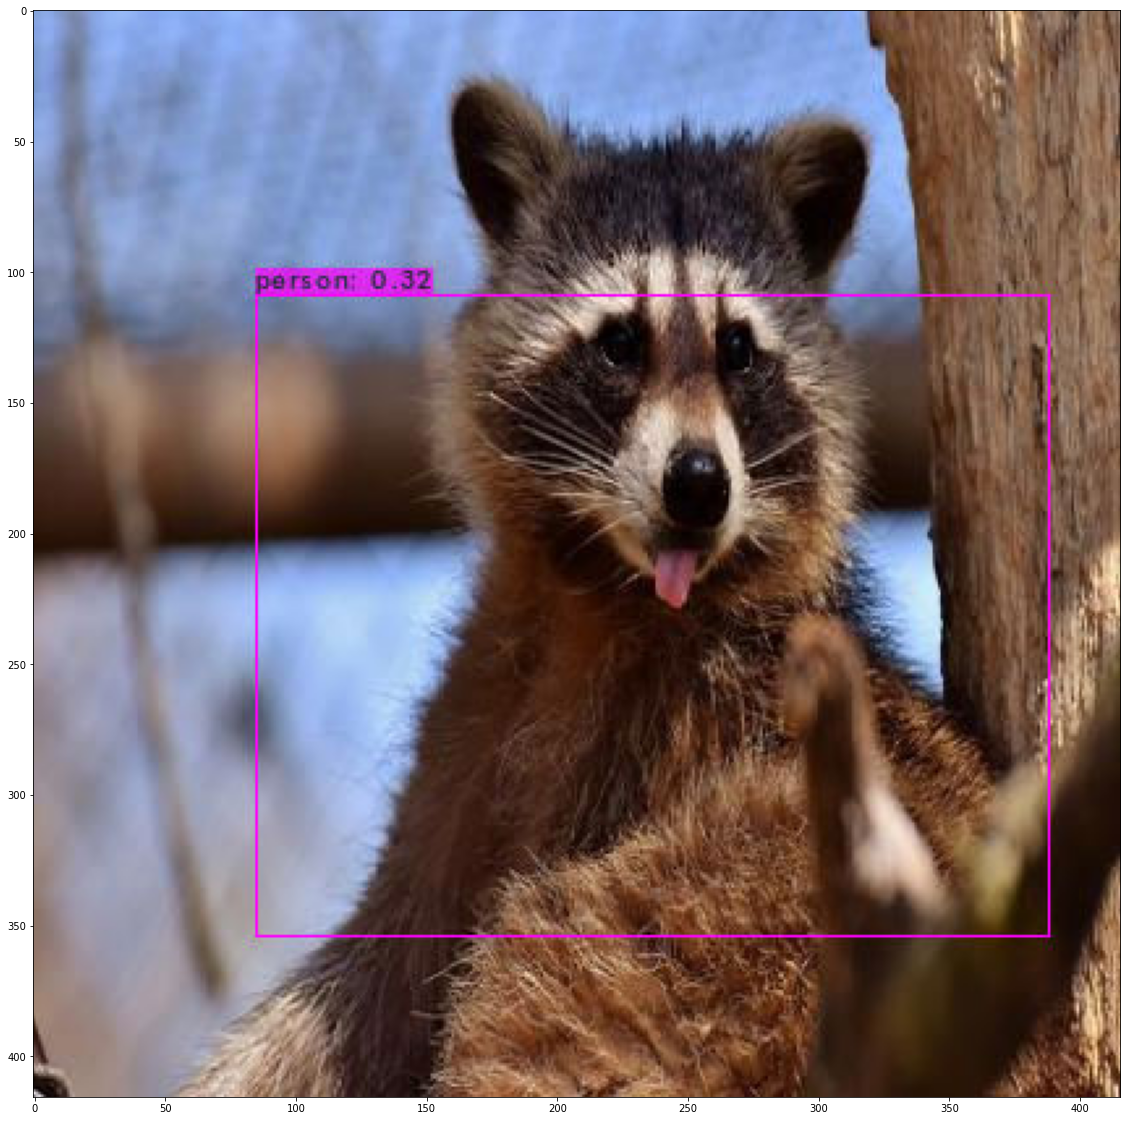

In [ ]:
pred = plt.imread('predictions.jpg')
plt.figure(figsize=(20,20))
plt.imshow(pred)
plt.show()